Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [140]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_attacking_midfielder"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80
MINDEST_POTENTIAL = 0
CENTRAL = 1
OFFENSE = 0.5

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']

PLAYER_ATTRIBUTES = ['Finishing','Acceleration','Composure','Interceptions',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
        'BallControl', 'SprintSpeed', 'Agility',
       'Reactions',  'ShotPower', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties']

# PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
#        'ShortPassing',  'Dribbling',  
#         'BallControl',  'SprintSpeed', 
#        'Reactions',    'Strength',
#        'LongShots', 'Aggression',  'Positioning', 'Vision'
# ]


In [141]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/757468280969868224', creation_time=1702060188704, experiment_id='757468280969868224', last_update_time=1702060188704, lifecycle_stage='active', name='offense_potential_attacking_midfielder', tags={}>

### Get Data

In [142]:
sql_prime = """
SELECT min(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={MINDEST_POTENTIAL})
GROUP BY ID
order by potential DESC;
"""



In [143]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [144]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [145]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [146]:
df = df[(df.central == CENTRAL)&(df.offense ==OFFENSE)]

# Training nur auf High Potentials
df = df[df.max_potential>MINDEST_POTENTIAL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
68.0    91
67.0    85
65.0    81
70.0    80
72.0    78
69.0    77
66.0    74
62.0    65
63.0    63
71.0    63
75.0    57
64.0    56
74.0    54
73.0    48
60.0    46
61.0    44
77.0    35
78.0    34
58.0    34
59.0    32
79.0    31
76.0    29
80.0    24
81.0    23
57.0    23
56.0    13
83.0    12
84.0    10
82.0    10
55.0     9
54.0     9
52.0     6
53.0     6
85.0     5
86.0     4
88.0     4
51.0     3
87.0     3
90.0     2
91.0     1
89.0     1
Name: count, dtype: int64


In [147]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
245371,T. Almada,2021,19.0,19.0,22.0,89.0,89.0,73.0,79.0,79.0,test,CAM
233927,Lucas Paquetá,2020,21.0,21.0,24.0,89.0,89.0,79.0,82.0,82.0,test,CAM
220834,Marco Asensio,2017,20.0,20.0,22.0,89.0,89.0,81.0,85.0,85.0,train,CAM
256630,F. Wirtz,2021,17.0,17.0,20.0,88.0,88.0,68.0,86.0,86.0,test,CAM
251570,R. Cherki,2021,16.0,16.0,19.0,88.0,88.0,67.0,75.0,75.0,test,CAM


In [148]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [149]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [150]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

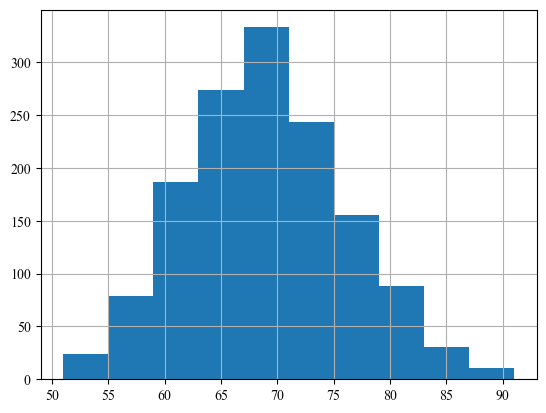

In [151]:
df['target'].hist()

In [152]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [153]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [154]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [155]:
y_train.describe()

count    868.000000
mean      69.221198
std        6.897631
min       51.000000
25%       65.000000
50%       69.000000
75%       74.000000
max       90.000000
Name: target, dtype: float64

In [156]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [157]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [158]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [159]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


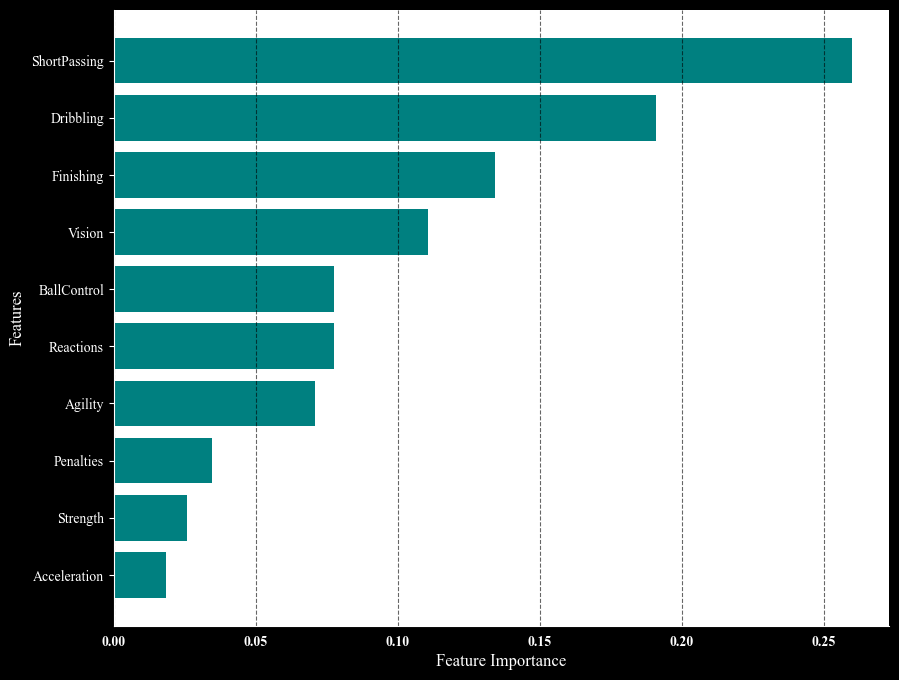

Using 222 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


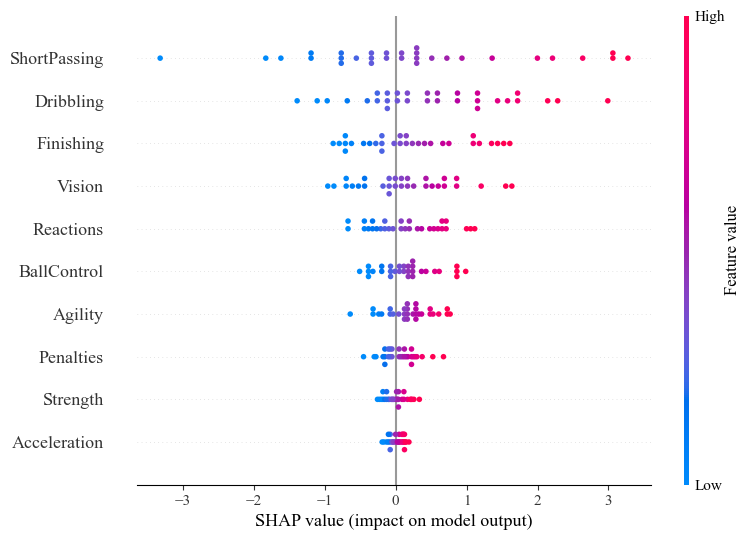

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       219
        True       0.67      0.67      0.67         3

    accuracy                           0.99       222
   macro avg       0.83      0.83      0.83       222
weighted avg       0.99      0.99      0.99       222

r2 0.411910241014237
mse 22.009334405869666
mae 3.909570040227407
Huber Regression training----->


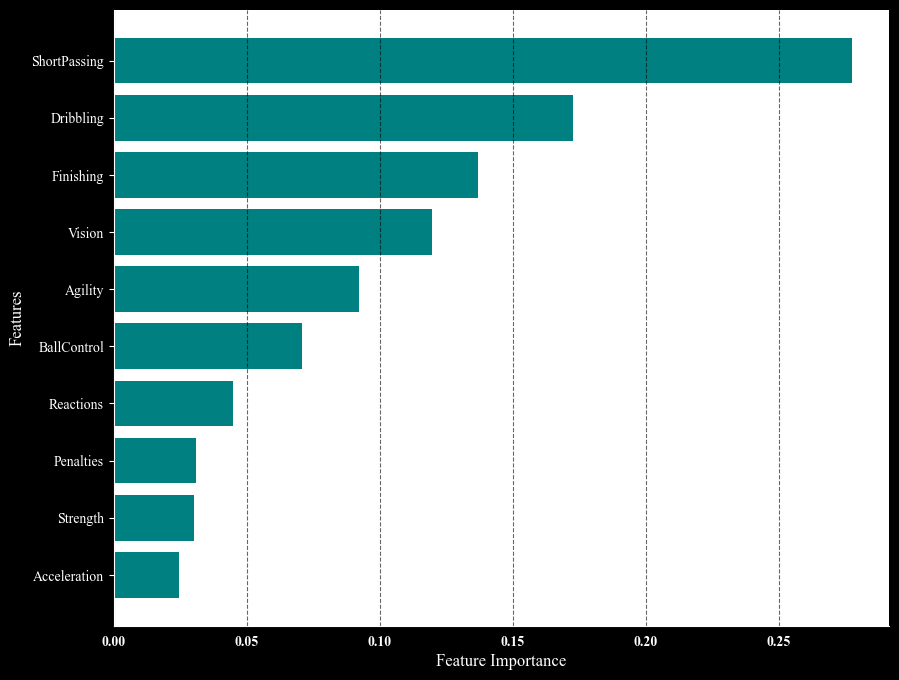

Using 222 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


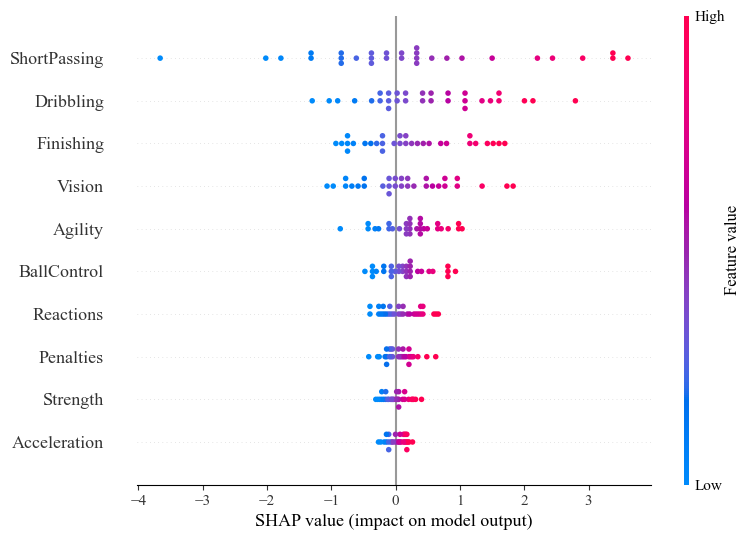

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       219
        True       0.67      0.67      0.67         3

    accuracy                           0.99       222
   macro avg       0.83      0.83      0.83       222
weighted avg       0.99      0.99      0.99       222

r2 0.4499791916351039
mse 20.584599062509465
mae 3.7829100638631776
Linear Regression training----->


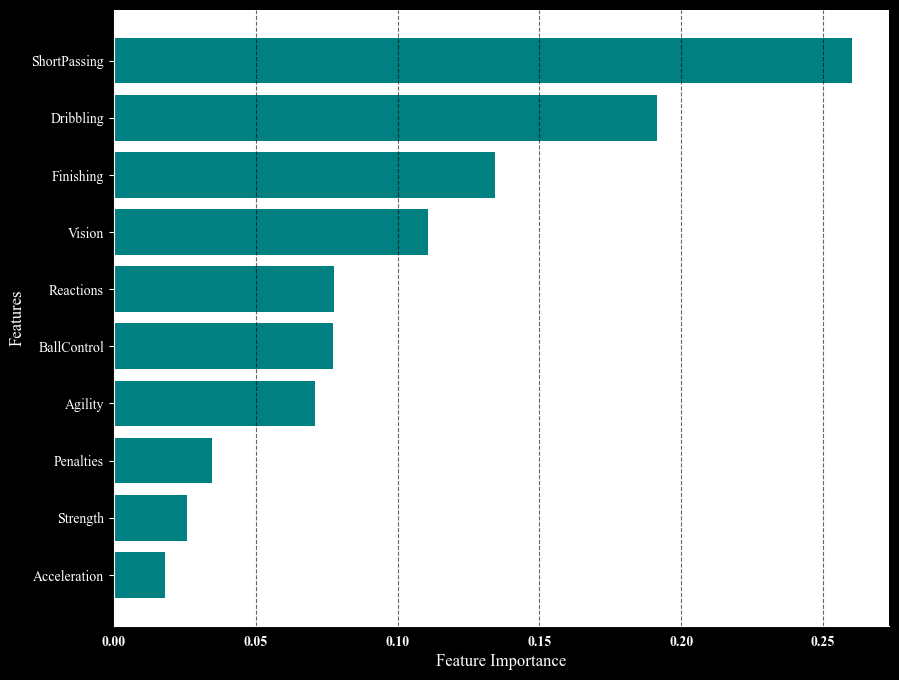

Using 222 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


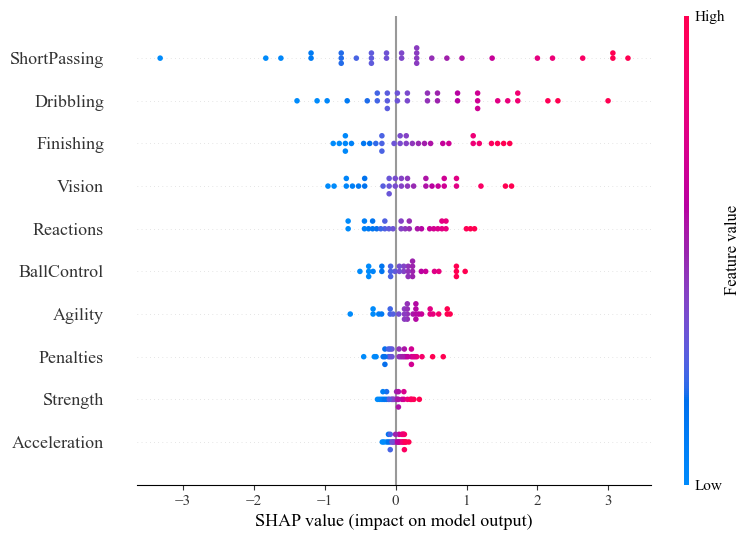

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       219
        True       0.67      0.67      0.67         3

    accuracy                           0.99       222
   macro avg       0.83      0.83      0.83       222
weighted avg       0.99      0.99      0.99       222

r2 0.41190287309923057
mse 22.009610151030625
mae 3.9096495288697826
Model: Ridge Regression
Mean Squared Error: 22.01
Mean Absolute Error: 3.91
R2 Score: 0.41

Model: Huber Regression
Mean Squared Error: 20.58
Mean Absolute Error: 3.78
R2 Score: 0.45

Model: Linear Regression
Mean Squared Error: 22.01
Mean Absolute Error: 3.91
R2 Score: 0.41



In [160]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    #  'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    #  'XGBoost Regressor': XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)
        print("r2",r2)
        print("mse",mse)
        print("mae",mae)
     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [161]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [162]:
X_train.describe()

,Finishing,Acceleration,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,ShotPower,Strength,LongShots,Aggression,Positioning,Vision,Penalties
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,51.171659,69.711982,19.861751,32.346774,63.114055,48.367512,63.487327,53.654378,49.471198,63.839862,69.350230,70.117512,55.467742,57.384793,50.087558,50.171659,45.441244,54.048387,59.669355,52.202765
std,9.273707,8.552032,27.007270,10.471394,7.256521,8.581905,8.026259,10.068755,10.586616,7.392657,6.888093,10.441467,7.993372,8.309295,11.921956,11.281520,10.294062,8.842983,7.601076,8.195444
min,22.000000,34.000000,0.000000,11.000000,38.000000,29.000000,40.000000,23.000000,22.000000,41.000000,40.000000,39.000000,33.000000,29.000000,21.000000,25.000000,13.000000,32.000000,40.000000,22.000000
25%,44.000000,64.000000,0.000000,25.000000,59.000000,42.000000,58.000000,46.000000,42.000000,59.000000,65.000000,62.750000,50.000000,52.000000,41.000000,42.000000,39.000000,48.000000,54.000000,46.000000
50%,52.000000,70.000000,0.000000,29.000000,64.000000,48.000000,64.000000,53.000000,48.000000,64.000000,69.000000,71.000000,55.000000,57.000000,51.000000,50.000000,44.000000,54.000000,60.000000,52.000000
75%,58.000000,75.000000,52.000000,38.000000,68.000000,54.000000,69.000000,61.000000,56.000000,68.000000,74.000000,78.000000,61.000000,63.000000,59.000000,58.000000,51.000000,60.000000,65.000000,58.000000
max,75.000000,92.000000,74.000000,67.000000,86.000000,76.000000,92.000000,85.000000,84.000000,91.000000,90.000000,94.000000,82.000000,83.000000,84.000000,80.000000,81.000000,82.000000,83.000000,75.000000


In [163]:
y_test.describe()

count    222.000000
mean      66.297297
std        6.131433
min       52.000000
25%       62.000000
50%       65.500000
75%       70.000000
max       86.000000
Name: target, dtype: float64

In [164]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [165]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

222

<Axes: >

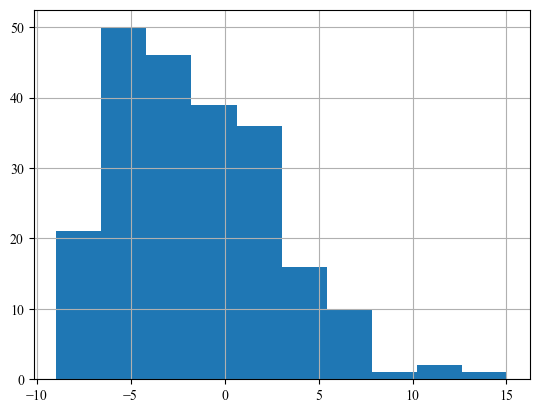

In [166]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

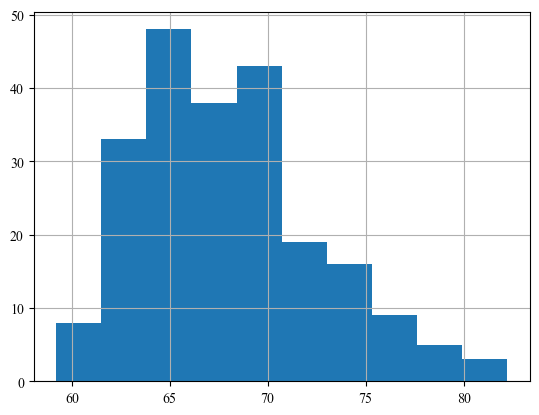

In [167]:
result_df.sort_values(ascending=False).hist()

In [168]:
(y_test-result_df).describe()

count    222.000000
mean      -1.644594
std        4.238020
min       -8.964570
25%       -4.916087
50%       -2.097428
75%        1.001216
max       15.031252
dtype: float64

In [169]:
outlier = (y_test-result_df)>5
X_test[outlier]


,,,Finishing,Acceleration,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,ShotPower,Strength,LongShots,Aggression,Positioning,Vision,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,
256630,F. Wirtz,2021,66.0,72.0,57.0,37.0,67.0,59.0,74.0,61.0,52.0,76.0,76.0,84.0,57.0,62.0,50.0,63.0,51.0,58.0,65.0,60.0
246863,F. Nmecha,2020,49.0,73.0,65.0,40.0,63.0,53.0,62.0,60.0,48.0,59.0,77.0,76.0,57.0,62.0,58.0,54.0,51.0,57.0,66.0,55.0
252837,Nico Ribaudo,2020,48.0,78.0,57.0,28.0,65.0,38.0,62.0,61.0,41.0,65.0,75.0,71.0,55.0,52.0,47.0,41.0,40.0,58.0,60.0,48.0
245055,A. Moreno,2020,55.0,60.0,67.0,35.0,62.0,50.0,67.0,54.0,51.0,65.0,67.0,59.0,63.0,65.0,56.0,60.0,46.0,65.0,63.0,55.0
246923,J. Ramsey,2020,36.0,57.0,62.0,29.0,63.0,44.0,48.0,47.0,45.0,59.0,62.0,53.0,46.0,45.0,49.0,31.0,41.0,46.0,55.0,45.0
239778,J. Moder,2020,58.0,63.0,52.0,61.0,64.0,33.0,53.0,41.0,36.0,62.0,59.0,69.0,52.0,63.0,76.0,58.0,58.0,54.0,59.0,40.0
246928,Iván Martín,2020,57.0,60.0,62.0,40.0,66.0,59.0,65.0,55.0,62.0,64.0,58.0,61.0,55.0,49.0,42.0,51.0,37.0,54.0,60.0,70.0
252240,A. Soñora,2020,44.0,55.0,58.0,25.0,68.0,48.0,60.0,60.0,55.0,59.0,69.0,56.0,52.0,63.0,43.0,37.0,42.0,44.0,63.0,52.0
247640,B. Teixeira,2020,45.0,55.0,48.0,41.0,61.0,37.0,56.0,46.0,45.0,58.0,61.0,67.0,52.0,48.0,53.0,36.0,61.0,53.0,56.0,53.0


In [170]:
y_test[outlier]

ID      Name             FIFA
256630  F. Wirtz         2021    86.0
246863  F. Nmecha        2020    78.0
252837  Nico Ribaudo     2020    74.0
245055  A. Moreno        2020    76.0
246923  J. Ramsey        2020    78.0
239778  J. Moder         2020    74.0
246928  Iván Martín      2020    76.0
252240  A. Soñora        2020    74.0
247640  B. Teixeira      2020    71.0
248175  M. Knudsen       2020    67.0
255917  Goh Young Jun    2021    70.0
255533  Y. Ndayishimiye  2021    75.0
256782  S. Nanasi        2021    68.0
256604  D. Luna          2021    66.0
246946  I. Coulibaly     2020    69.0
257191  A. Stach         2021    76.0
251617  A. Gigovic       2020    68.0
Name: target, dtype: float64

In [171]:
result_df[outlier]

ID      Name             FIFA
256630  F. Wirtz         2021    74.703447
246863  F. Nmecha        2020    69.331326
252837  Nico Ribaudo     2020    68.900085
245055  A. Moreno        2020    69.388623
246923  J. Ramsey        2020    62.968748
239778  J. Moder         2020    67.898304
246928  Iván Martín      2020    69.861076
252240  A. Soñora        2020    67.625497
247640  B. Teixeira      2020    65.584316
248175  M. Knudsen       2020    61.460009
255917  Goh Young Jun    2021    64.912164
255533  Y. Ndayishimiye  2021    68.772612
256782  S. Nanasi        2021    62.170697
256604  D. Luna          2021    59.196164
246946  I. Coulibaly     2020    63.417428
257191  A. Stach         2021    64.869107
251617  A. Gigovic       2020    62.536278
dtype: float64

In [172]:
(y_test/result_df).describe()

count    222.000000
mean       0.975787
std        0.063633
min        0.855327
25%        0.929426
50%        0.970341
75%        1.015403
max        1.238710
dtype: float64

In [173]:
(y_test/result_df).describe()

count    222.000000
mean       0.975787
std        0.063633
min        0.855327
25%        0.929426
50%        0.970341
75%        1.015403
max        1.238710
dtype: float64

In [174]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.72277434],
       [0.72277434, 1.        ]])

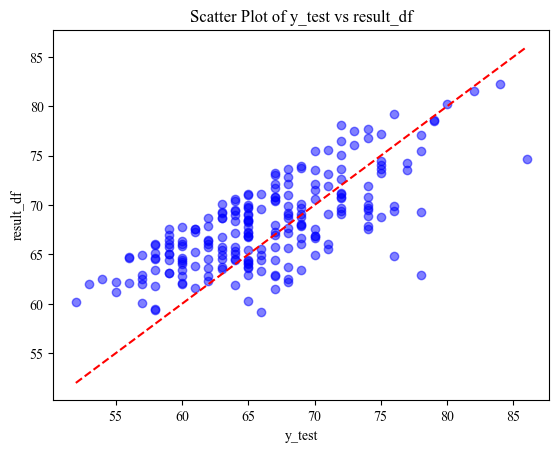

In [175]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [176]:
result_df = result_df.sort_values(ascending=False)

In [177]:
sum(X_train_scaled_df.index.get_level_values('ID')==239085)

0

In [178]:
result_df.head(50)

ID      Name               FIFA
237692  P. Foden           2021    82.208747
233927  Lucas Paquetá      2020    81.496301
241095  N. Vlašić          2020    80.228439
234505  Evander            2021    79.232941
244261  L. Majer           2020    78.572691
245371  T. Almada          2021    78.504511
230478  Jairinhazo         2021    78.090380
230267  Sebas Couteira     2021    77.735296
230277  Gustavo Lobateiro  2021    77.480138
252931  L. Ivanušec        2021    77.180151
253150  M. Ndayishimiye    2021    77.046436
244863  Y. Benrahou        2021    76.767407
230522  Nascimentardo      2021    76.455454
246419  Y. Verschaeren     2020    76.088462
230459  Tiago Pombeira     2021    75.614287
240787  H. Traorè          2020    75.506548
230489  Diogildo Peixe     2021    75.477889
252038  Romário Baró       2020    75.093475
256630  F. Wirtz           2021    74.703447
258208  O. Lingr           2021    74.411793
246960  M. Ihattaren       2020    74.237196
251570  R. Cherki      

In [179]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name           FIFA
237692  P. Foden       2021    82.208747
233927  Lucas Paquetá  2020    81.496301
241095  N. Vlašić      2020    80.228439
dtype: float64

In [180]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name      FIFA
256630  F. Wirtz  2021    74.703447
dtype: float64

In [181]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name       FIFA
241095  N. Vlašić  2020    80.228439
dtype: float64

In [182]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

218


ID      Name               FIFA
252937  Y. Gboho           2021    73.731751
234018  Sandeiro Leal      2021    73.955111
251570  R. Cherki          2021    74.058319
246960  M. Ihattaren       2020    74.237196
258208  O. Lingr           2021    74.411793
252038  Romário Baró       2020    75.093475
230489  Diogildo Peixe     2021    75.477889
240787  H. Traorè          2020    75.506548
230459  Tiago Pombeira     2021    75.614287
246419  Y. Verschaeren     2020    76.088462
230522  Nascimentardo      2021    76.455454
244863  Y. Benrahou        2021    76.767407
253150  M. Ndayishimiye    2021    77.046436
252931  L. Ivanušec        2021    77.180151
230277  Gustavo Lobateiro  2021    77.480138
230267  Sebas Couteira     2021    77.735296
230478  Jairinhazo         2021    78.090380
245371  T. Almada          2021    78.504511
244261  L. Majer           2020    78.572691
234505  Evander            2021    79.232941
dtype: float64

In [183]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       206
        True       0.61      0.69      0.65        16

    accuracy                           0.95       222
   macro avg       0.79      0.83      0.81       222
weighted avg       0.95      0.95      0.95       222



In [184]:
X_train[X_train.index.get_level_values('ID')==239085]

,,,Finishing,Acceleration,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,ShotPower,Strength,LongShots,Aggression,Positioning,Vision,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,
